<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Présentation" data-toc-modified-id="Présentation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Présentation</a></span></li><li><span><a href="#Import-des-librairies" data-toc-modified-id="Import-des-librairies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import des librairies</a></span></li><li><span><a href="#Test-de-l'api-Microsoft-du-service-cognitif" data-toc-modified-id="Test-de-l'api-Microsoft-du-service-cognitif-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test de l'api Microsoft du service cognitif</a></span></li><li><span><a href="#Chargement-du-jeu-de-données" data-toc-modified-id="Chargement-du-jeu-de-données-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Chargement du jeu de données</a></span></li><li><span><a href="#Fonction-de-prédiction-adaptée-à-notre-cas" data-toc-modified-id="Fonction-de-prédiction-adaptée-à-notre-cas-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fonction de prédiction adaptée à notre cas</a></span></li><li><span><a href="#Application-sur-le-jeu-de-données" data-toc-modified-id="Application-sur-le-jeu-de-données-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Application sur le jeu de données</a></span><ul class="toc-item"><li><span><a href="#Analyse-des-prédictions-neutres" data-toc-modified-id="Analyse-des-prédictions-neutres-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Analyse des prédictions neutres</a></span></li><li><span><a href="#Prise-de-décision-sur-les-scores-neutres" data-toc-modified-id="Prise-de-décision-sur-les-scores-neutres-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Prise de décision sur les scores neutres</a></span><ul class="toc-item"><li><span><a href="#Solution-manuelle" data-toc-modified-id="Solution-manuelle-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Solution manuelle</a></span></li><li><span><a href="#Solution-automatique-avec-un-modèle-de-régression-logistique" data-toc-modified-id="Solution-automatique-avec-un-modèle-de-régression-logistique-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Solution automatique avec un modèle de régression logistique</a></span></li></ul></li></ul></li></ul></div>

# Présentation

# Import des librairies

In [1]:
import os
from time import time
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean

from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from dotenv import load_dotenv

# Test de l'api Microsoft du service cognitif

https://docs.microsoft.com/fr-fr/azure/cognitive-services/language-service/sentiment-opinion-mining/quickstart?pivots=programming-language-python

https://portal.azure.com/cobrand/?id=12&mkt=DA-DK&cbcxt=azubill

In [3]:
load_dotenv()

key      = os.getenv("YOUR_TRANSLATOR_KEY")
endpoint = os.getenv("YOUR_TRANSLATOR_ENDPOINT")

In [4]:
# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [4]:
# Example function for detecting sentiment in text
def sentiment_analysis_example(client):

    documents = ["I had the best day of my life. I wish you were there with me."]
    response = client.analyze_sentiment(documents=documents)[0]
    print("Document Sentiment: {}".format(response.sentiment))
    print("Overall scores: positive={0:.2f}; neutral={1:.2f}; negative={2:.2f} \n".format(
        response.confidence_scores.positive,
        response.confidence_scores.neutral,
        response.confidence_scores.negative,
    ))
    
    for idx, sentence in enumerate(response.sentences):
        print("Sentence: {}".format(sentence.text))
        print("Sentence {} sentiment: {}".format(idx+1, sentence.sentiment))
        print("Sentence score:\nPositive={0:.2f}\nNeutral={1:.2f}\nNegative={2:.2f}\n".format(
            sentence.confidence_scores.positive,
            sentence.confidence_scores.neutral,
            sentence.confidence_scores.negative,
        ))
          
sentiment_analysis_example(client)

Document Sentiment: positive
Overall scores: positive=0.99; neutral=0.00; negative=0.00 

Sentence: I had the best day of my life. 
Sentence 1 sentiment: positive
Sentence score:
Positive=0.99
Neutral=0.00
Negative=0.00

Sentence: I wish you were there with me.
Sentence 2 sentiment: neutral
Sentence score:
Positive=0.25
Neutral=0.72
Negative=0.03



# Chargement du jeu de données

In [5]:
twitter_data = pd.read_csv(
    "tweet_dataset.csv",
    encoding="ISO-8859-1"
)

twitter_data

,target,text,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that is a bummer you shoulda got david ca...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i am mad why am i...
...,...,...,...
1595,4,@rentan It can only happen to you.,it can only happen to you
1596,4,@bonnie_klide I just think the cab ride throu...,i just think the cab ride through sofia and th...
1597,4,@ninjaguitarsex I'm pretty sure the show part ...,i am pretty sure the show part is just for bef...
1598,4,"@trentvanegas twitter ain't broke, Trent, they...",twitter are not broke trent they got plenty of...


# Fonction de prédiction adaptée à notre cas

On veut retourner les trois scores de prédiction

In [6]:
tweet_example = twitter_data.iloc[0][2]
tweet_example

'awww that is a bummer you shoulda got david carr of third day to do it'

In [7]:
# Example function for detecting sentiment in text
def sentiment_analysis_example(client, tweet):

    response = client.analyze_sentiment(documents=[tweet])[0]

    positive_score = []
    neutral_score  = []
    negative_score = []
    for sentence in response.sentences:
        positive_score.append(sentence.confidence_scores.positive)
        neutral_score.append(sentence.confidence_scores.neutral)
        negative_score.append(sentence.confidence_scores.negative)

    scores = {
        "positve" : mean(positive_score),
        "neutral" : mean(neutral_score),
        "negative": mean(negative_score)
    }
    
    return scores

In [8]:
sentiment_analysis_example(client, tweet_example)

{'positve': 0.01, 'neutral': 0.01, 'negative': 0.99}

# Application sur le jeu de données

In [14]:
import time

positive_score = []
neutral_score  = []
negative_score = []

for idx, row in tqdm(twitter_data.iterrows(), total=len(twitter_data)):
    try:
        azure_pred = sentiment_analysis_example(client, row.cleaned_text)
        positive_score.append(azure_pred["positve"])
        neutral_score.append(azure_pred["neutral"])
        negative_score.append(azure_pred["negative"])
        time.sleep(1)
    except Exception as e:
        positive_score.append(0)
        neutral_score.append(0)
        negative_score.append(0)
        print(idx, row.cleaned_text)
        print(e)
        print("="*50)
    
twitter_data["positive_score"] = positive_score
twitter_data["neutral_score"]  = neutral_score
twitter_data["negative_score"] = negative_score
twitter_data.to_csv("tweet_dataset_azure_pred.csv", index=False)
twitter_data

  0%|          | 0/1600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [2]:
twitter_data = pd.read_csv("tweet_dataset_azure_pred.csv")
twitter_data

,target,text,cleaned_text,positive_score,neutral_score,negative_score
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that is a bummer you shoulda got david ca...,0.01,0.01,0.99
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,0.00,0.01,0.99
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,0.07,0.03,0.90
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,0.01,0.05,0.94
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i am mad why am i...,0.01,0.02,0.97
...,...,...,...,...,...,...
1595,4,@rentan It can only happen to you.,it can only happen to you,0.03,0.93,0.03
1596,4,@bonnie_klide I just think the cab ride throu...,i just think the cab ride through sofia and th...,0.97,0.02,0.01
1597,4,@ninjaguitarsex I'm pretty sure the show part ...,i am pretty sure the show part is just for bef...,0.30,0.63,0.07
1598,4,"@trentvanegas twitter ain't broke, Trent, they...",twitter are not broke trent they got plenty of...,0.47,0.17,0.36


In [3]:
conditions = [
    (twitter_data['positive_score']>twitter_data['negative_score']),
    (twitter_data['negative_score']>twitter_data['positive_score']),
    (twitter_data['negative_score']==twitter_data['positive_score'])]

choices = [4, 0, 2]

twitter_data['summary_score'] = np.select(conditions, choices)
twitter_data

,target,text,cleaned_text,positive_score,neutral_score,negative_score,summary_score
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that is a bummer you shoulda got david ca...,0.01,0.01,0.99,0
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,0.00,0.01,0.99,0
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,0.07,0.03,0.90,0
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,0.01,0.05,0.94,0
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i am mad why am i...,0.01,0.02,0.97,0
...,...,...,...,...,...,...,...
1595,4,@rentan It can only happen to you.,it can only happen to you,0.03,0.93,0.03,2
1596,4,@bonnie_klide I just think the cab ride throu...,i just think the cab ride through sofia and th...,0.97,0.02,0.01,4
1597,4,@ninjaguitarsex I'm pretty sure the show part ...,i am pretty sure the show part is just for bef...,0.30,0.63,0.07,4
1598,4,"@trentvanegas twitter ain't broke, Trent, they...",twitter are not broke trent they got plenty of...,0.47,0.17,0.36,4


## Analyse des prédictions neutres

In [4]:
neutral_score_df = twitter_data[["target", "cleaned_text"]][twitter_data["summary_score"]==2]
neutral_score_df

,target,cleaned_text
66,0,damm back to school tomorrow
91,0,wednesday my do not know what 2 do
164,0,yes sprint has 4g only in baltimore and chicag...
208,0,NaN
249,0,NaN
264,0,i have to take my sidekick back
282,0,NaN
317,0,i have to fill two hours
385,0,yes it will be it is only monday
396,0,the weather in canada is freezing


In [5]:
neutral_score_df["target"].value_counts()

4    18
0    14
Name: target, dtype: int64

## Prise de décision sur les scores neutres

In [6]:
def plot_confusion_matrix(y_test, y_pred, model_title="Tweets clean"):
    '''
    y_test=y_test, y_pred=y_pred, model_title="Tweets clean"
    '''

    # Create confusion matrix table
    cm = pd.crosstab(index=y_test,
                     columns=y_pred,
                     values=y_test,
                     aggfunc=lambda x: len(x),
                     normalize='index').mul(100)

    # Plot confusion matrix
    fig, ax0 = plt.subplots(1, 1, figsize=(5, 5))
    ax = sns.heatmap(cm, annot=True, fmt='.1f', cbar=False, cmap='Blues')

    for t in ax.texts:
        t.set_text(t.get_text() + " %")
    ax.xaxis.tick_top()  # x axis on top
    ax.xaxis.set_label_position('top')

    plt.ylabel('Réelle', fontweight='bold')
    plt.xlabel('Estimée', fontweight='bold')

    title = 'Matrice de confusion - ' + model_title
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    cr = classification_report(y_test, y_pred)

    print(cr)

### Solution manuelle

Il y a plus de positif que de neutre, on peut essayer de passer les messages neutres en positif pour réduire le taux d'erreur.

In [7]:
conditions = [
    (twitter_data['positive_score']>twitter_data['negative_score']),
    (twitter_data['negative_score']>twitter_data['positive_score']),
    (twitter_data['negative_score']==twitter_data['positive_score'])]

choices = [4, 0, 4]

twitter_data['binary_score'] = np.select(conditions, choices)
twitter_data

,target,text,cleaned_text,positive_score,neutral_score,negative_score,summary_score,binary_score
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that is a bummer you shoulda got david ca...,0.01,0.01,0.99,0,0
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,0.00,0.01,0.99,0,0
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,0.07,0.03,0.90,0,0
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,0.01,0.05,0.94,0,0
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i am mad why am i...,0.01,0.02,0.97,0,0
...,...,...,...,...,...,...,...,...
1595,4,@rentan It can only happen to you.,it can only happen to you,0.03,0.93,0.03,2,4
1596,4,@bonnie_klide I just think the cab ride throu...,i just think the cab ride through sofia and th...,0.97,0.02,0.01,4,4
1597,4,@ninjaguitarsex I'm pretty sure the show part ...,i am pretty sure the show part is just for bef...,0.30,0.63,0.07,4,4
1598,4,"@trentvanegas twitter ain't broke, Trent, they...",twitter are not broke trent they got plenty of...,0.47,0.17,0.36,4,4


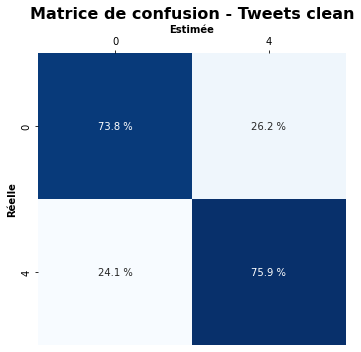

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       800
           4       0.74      0.76      0.75       800

    accuracy                           0.75      1600
   macro avg       0.75      0.75      0.75      1600
weighted avg       0.75      0.75      0.75      1600



In [8]:
y_test = twitter_data["target"]
y_pred = twitter_data["binary_score"]

plot_confusion_matrix(y_test, y_pred)

### Solution automatique avec un modèle de régression logistique

In [16]:
def train_and_plot_matrix(features:list):
    
    #split dataset in features and target variable
    X = twitter_data[features] # Features
    y = twitter_data.target # Target variable

    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
    
    X_train.to_csv("X_train.csv")
    X_test.to_csv("X_test.csv")
    y_train.to_csv("y_train.csv")
    y_test.to_csv("y_test.csv")

    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()

    # fit the model with data
    logreg.fit(X_train, y_train)

    y_pred = logreg.predict(X_test)

    plot_confusion_matrix(y_test, y_pred)

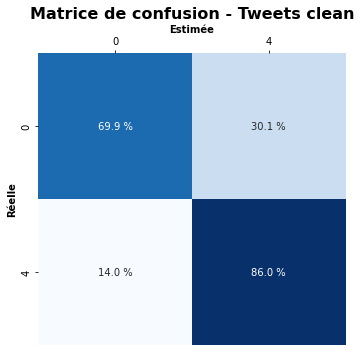

              precision    recall  f1-score   support

           0       0.84      0.70      0.76       163
           4       0.73      0.86      0.79       157

    accuracy                           0.78       320
   macro avg       0.79      0.78      0.78       320
weighted avg       0.79      0.78      0.78       320



In [17]:
features = ['positive_score', 'neutral_score', 'negative_score']
train_and_plot_matrix(features)

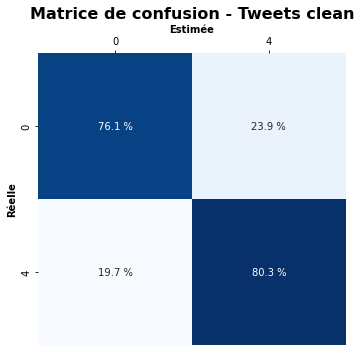

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       163
           4       0.76      0.80      0.78       157

    accuracy                           0.78       320
   macro avg       0.78      0.78      0.78       320
weighted avg       0.78      0.78      0.78       320



In [11]:
features = ['summary_score']
train_and_plot_matrix(features)